# Fine-tuning a Torch object detection model

This tutorial explains how to fine-tune `fasterrcnn_resnet50_fpn` using the Ray AI Runtime libraries for parallel data ingest and training.

Here's what you'll do:
1. Load raw images and [VOC-style](http://host.robots.ox.ac.uk/pascal/VOC/) annotations into a Dataset
2. Fine-tune `fasterrcnn_resnet50_fpn` (the backbone is pre-trained on ImageNet)
3. Evaluate the model's accuracy

You should be familiar with [PyTorch](https://pytorch.org/) before starting the
tutorial. If you need a refresher, read PyTorch's
[training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
tutorial.

## Before you begin

* Install the dependencies for Ray AI Runtime libraries.

In [1]:
!pip install 'ray[air]'

* Install `torch`, `torchmetrics`, `torchvision`, and `xmltodict`.

In [2]:
!pip install torch torchmetrics torchvision xmltodict

## Create a `Dataset`

You'll work with a subset of [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) that contains cats and dogs (the full dataset has 20 classes).

In [3]:
CLASS_TO_LABEL = {
    "background": 0,
    "cat": 1,
    "dog": 2,
}

The dataset contain two subdirectories: `JPEGImages` and `Annotations`. `JPEGImages` contains raw images, and
`Annotations` contains XML annotations.

```
AnimalDetection
├── Annotations
│   ├── 2007_000063.xml
│   ├── 2007_000528.xml
│   └──  ...
└── JPEGImages
    ├── 2007_000063.jpg
    ├── 2007_000528.jpg
    └──  ...
```

### Define a custom datasource

Each annotation describes the objects in an image.

For example, view this image of a dog:

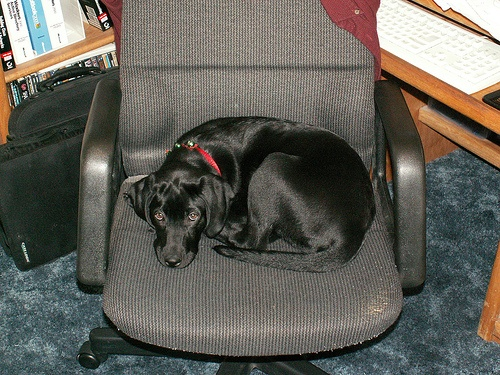

In [4]:
import io

from PIL import Image
import requests

response = requests.get("https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages/2007_000063.jpg")
image = Image.open(io.BytesIO(response.content))
image

Then, print the image's annotation:

In [5]:
!curl "https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/Annotations/2007_000063.xml"

<?xml version="1.0" encoding="utf-8"?>
<annotation>
	<folder>VOC2012</folder>
	<filename>2007_000063.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
	</source>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segmented>1</segmented>
	<object>
		<name>dog</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>123</xmin>
			<ymin>115</ymin>
			<xmax>379</xmax>
			<ymax>275</ymax>
		</bndbox>
	</object>
</annotation>

Notice how there's one object labeled "dog"

```
<name>dog</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
        <xmin>123</xmin>
        <ymin>115</ymin>
        <xmax>379</xmax>
        <ymax>275</ymax>
</bndbox>
```

[Ray Data](data) lets you read and preprocess data in parallel. Ray Data doesn't
have built-in support for VOC-style annotations, so you'll need to define a custom
datasource.

A Datasource is an object that reads data of a particular type. For example, Ray Data
implements a Datasource that reads CSV files. Your datasource will parse labels and
bounding boxes from XML files. Later, you'll read the corresponding images.

To implement the datasource, extend the built-in `FileBasedDatasource` class
and override the `_read_file` method.

In [6]:
from typing import List, Tuple

import xmltodict
import pandas as pd
import pyarrow as pa

from ray.data.datasource import FileBasedDatasource
from ray.data.extensions import TensorArray


class VOCAnnotationDatasource(FileBasedDatasource):
    def _read_file(self, f: pa.NativeFile, path: str, **reader_args) -> pd.DataFrame:
        text = f.read().decode("utf-8")
        annotation = xmltodict.parse(text)["annotation"]

        objects = annotation["object"]
        # If there's one object, `objects` is a `dict`; otherwise, it's a `list[dict]`.
        if isinstance(objects, dict):
            objects = [objects]

        boxes: List[Tuple] = []
        for obj in objects:
            x1 = float(obj["bndbox"]["xmin"])
            y1 = float(obj["bndbox"]["ymin"])
            x2 = float(obj["bndbox"]["xmax"])
            y2 = float(obj["bndbox"]["ymax"])
            boxes.append((x1, y1, x2, y2))

        labels: List[int] = [CLASS_TO_LABEL[obj["name"]] for obj in objects]

        filename = annotation["filename"]

        return pd.DataFrame(
            {
                "boxes": TensorArray([boxes]),
                "labels": TensorArray([labels]),
                "filename": [filename],
            }
        )

    def _rows_per_file(self):
        return 1

### Read annotations

To load the annotations into a `Dataset`, call `ray.data.read_datasource` and pass
the custom datasource to the constructor. Ray will read the annotations in parallel.

In [7]:
import os
import ray


annotations: ray.data.Dataset = ray.data.read_datasource(
    VOCAnnotationDatasource(), paths="s3://anonymous@air-example-data/AnimalDetection/Annotations"
)

find: ‘.git’: No such file or directory
2023-03-01 13:05:51,314	INFO worker.py:1360 -- Connecting to existing Ray cluster at address: 10.0.26.109:6379...
2023-03-01 13:05:51,327	INFO worker.py:1548 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_mf1limh36cs2yrh9wkf6h2a75k/services?redirect_to=dashboard 
2023-03-01 13:05:52,269	INFO packaging.py:330 -- Pushing file package 'gcs://_ray_pkg_00aff5a3a84ab6438be1961b97a5beaa.zip' (266.32MiB) to Ray cluster...
2023-03-01 13:05:58,529	INFO packaging.py:343 -- Successfully pushed file package 'gcs://_ray_pkg_00aff5a3a84ab6438be1961b97a5beaa.zip'.


Look at the first two samples. `VOCAnnotationDatasource` should've correctly parsed
labels and bounding boxes.

In [8]:
annotations.take(2)

[{'boxes': array([[123., 115., 379., 275.]]),
  'labels': 2,
  'filename': '2007_000063.jpg'},
 {'boxes': array([[124.,  68., 319., 310.]]),
  'labels': 1,
  'filename': '2007_000528.jpg'}]

### Load images into memory

Each row of `annotations` contains the filename of an image.

Write a user-defined function that loads these images. For each annotation, your function will:
1. Open the image associated with the annotation.
2. Add the image to a new `"image"` column.

In [9]:
from typing import Dict

import numpy as np
from PIL import Image


def read_images(batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    images: List[np.ndarray] = []
    for filename in batch["filename"]:
        url = os.path.join("https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages", filename)
        response = requests.get(url)
        image = Image.open(io.BytesIO(response.content))
        images.append(np.array(image))
    batch["image"] = np.array(images, dtype=object)
    return batch


dataset = annotations.map_batches(read_images)
dataset

2023-03-01 13:06:08,005	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[read->MapBatches(read_images)]
read->MapBatches(read_images): 100%|██████████| 128/128 [00:24<00:00,  5.25it/s]


### Split the dataset into train and test sets

Once you've created a `Dataset`, split the dataset into train and test sets.

In [10]:
train_dataset, test_dataset = dataset.train_test_split(0.2)

## Define preprocessing logic

A `Preprocessor` is an object that defines preprocessing logic. It's the standard way
to preprocess data with Ray.

Create two preprocessors: one to transpose and scale images (`ToTensor`), and another to
randomly augment images every epoch (`RandomHorizontalFlip`). You'll later pass these
preprocessors to a `Trainer`.


In [11]:
from torchvision import transforms

from ray.data.preprocessors import TorchVisionPreprocessor

transform = transforms.ToTensor()
preprocessor = TorchVisionPreprocessor(columns=["image"], transform=transform)

per_epoch_transform = transforms.RandomHorizontalFlip(p=0.5)
per_epoch_preprocessor = TorchVisionPreprocessor(columns=["image"], transform=per_epoch_transform)

## Fine-tune the object detection model

### Define the training loop

Write a function that trains `fasterrcnn_resnet50_fpn`. Your code will look like
standard Torch code with a few changes.

Here are a few things to point out:
1. Distribute the model with `ray.train.torch.prepare_model`. Don't use `DistributedDataParallel`.
2. Pass your Dataset to the Trainer. The Trainer automatically shards the data across workers.
3. Iterate over data with `DataIterator.iter_batches`. Don't use a Torch `DataLoader`.
4. Pass preprocessors to the Trainer.

In addition, report metrics and checkpoints with `train.report`. `train.report` tracks these metrics in Ray AIR's internal bookkeeping, allowing you to monitor training and analyze training runs after they've finished.

In [12]:
import torch
from torchvision import models

from ray import train
from ray.train import Checkpoint


def train_one_epoch(*, model, optimizer, batch_size, epoch):
    model.train()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=250
        )

    device = ray.train.torch.get_device()
    train_dataset_shard = train.get_dataset_shard("train")

    batches = train_dataset_shard.iter_batches(batch_size=batch_size)
    for batch in batches:
        inputs = [torch.as_tensor(image).to(device) for image in batch["image"]]
        targets = [
            {
                "boxes": torch.as_tensor(boxes).to(device),
                "labels": torch.as_tensor(labels).to(device),
            }
            for boxes, labels in zip(batch["boxes"], batch["labels"])
        ]
        loss_dict = model(inputs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        train.report(
            {
                "losses": losses.item(),
                "epoch": epoch,
                "lr": optimizer.param_groups[0]["lr"],
                **{key: value.item() for key, value in loss_dict.items()},
            }
        )


def train_loop_per_worker(config):
    # By default, `fasterrcnn_resnet50_fpn`'s backbone is pre-trained on ImageNet.
    model = models.detection.fasterrcnn_resnet50_fpn(num_classes=3)
    model = ray.train.torch.prepare_model(model)
    parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        parameters,
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"],
    )
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=config["lr_steps"], gamma=config["lr_gamma"]
    )

    for epoch in range(0, config["epochs"]):
        train_one_epoch(
            model=model,
            optimizer=optimizer,
            batch_size=config["batch_size"],
            epoch=epoch,
        )
        lr_scheduler.step()
        checkpoint = Checkpoint.from_dict(
            {
                "model": model.module.state_dict(),
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
                "config": config,
                "epoch": epoch,
            }
        )
        train.report({}, checkpoint=checkpoint)

### Fine-tune the model

Once you've defined the training loop, create a `TorchTrainer` and pass the training
loop to the constructor. Then, call `TorchTrainer.fit` to train the model.

In [13]:
from ray.train import ScalingConfig
from ray.train.torch import TorchTrainer


# The following transform operation is lazy.
# It will be re-run every epoch.
train_dataset = per_epoch_preprocessor.transform(train_dataset)

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={
        "batch_size": 2,
        "lr": 0.02,
        "epochs": 1,  # You'd normally train for 26 epochs.
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "lr_steps": [16, 22],
        "lr_gamma": 0.1,
    },
    scaling_config=ScalingConfig(num_workers=4, use_gpu=True),
    datasets={"train": train_dataset},
    preprocessor=preprocessor,
)
results = trainer.fit()

2023-03-01 13:06:39,486	INFO instantiator.py:21 -- Created a temporary directory at /tmp/tmp1stz0z_r
2023-03-01 13:06:39,488	INFO instantiator.py:76 -- Writing /tmp/tmp1stz0z_r/_remote_module_non_scriptable.py


(RayTrainWorker pid=175611) 2023-03-01 13:06:56,331	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=4]
(TorchTrainer pid=175347) 2023-03-01 13:07:00,615	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[TorchVisionPreprocessor] -> AllToAllOperator[randomize_block_order]


(autoscaler +1m25s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +1m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(TorchTrainer pid=175347) /home/ray/anaconda3/lib/python3.9/site-packages/ray/train/_internal/dataset_iterator.py:64: UserWarning: session.get_dataset_shard returns a ray.data.DataIterator instead of a Dataset/DatasetPipeline as of Ray v2.3. Use iter_torch_batches(), to_tf(), or iter_batches() to iterate over one epoch. See https://docs.ray.io/en/latest/data/api/dataset_iterator.html for full DataIterator docs.
(TorchTrainer pid=175347)   warnings.warn(
Stage 1:   0%|          | 0/1 [00:00<?, ?it/s]
(RayTrainWorker pid=175611) 2023-03-01 13:07:26,094	INFO train_loop_utils.py:307 -- Moving model to device: cuda:3
(RayTrainWorker pid=175611) 2023-03-01 13:07:29,092	INFO train_loop_utils.py:367 -- Wrapping provided model in DistributedDataParallel.
Stage 0: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]2023-03-01 13:07:29,436	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[TorchVisionPreprocessor]
(PipelineSplitExecutorCoordinator pid=191352) 
Stage 

Trial name,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
TorchTrainer_f5aa9_00000,2023-03-01_13-08-41,True,0,ip-10-0-26-109,244,10.0.26.109,175347,True,108.703,4.2088,108.703,1677704918,244,f5aa9_00000


(RayTrainWorker pid=175612) 2023-03-01 13:07:41,980	INFO distributed.py:1027 -- Reducer buckets have been rebuilt in this iteration.
(PipelineSplitExecutorCoordinator pid=191352) 
Stage 0: : 4it [01:11, 25.77s/it]2023-03-01 13:08:37,068	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[TorchVisionPreprocessor]
(RayTrainWorker pid=175614) 2023-03-01 13:08:37,464	WARNING plan.py:527 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#data-and-tune
2023-03-01 13:08:45,074	INFO tune.py:825 -- Total run time: 125.51 seconds (125.36 seconds for the tuning loop).


## Next steps

- {ref}`End-to-end: Offline Batch Inference <batch_inference_home>`